In [1]:
# import packages and libraries
import pandas as pd
import lightgbm
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import tools
import uuid
import os
init_notebook_mode(connected=True)
from sklearn.neighbors import KNeighborsRegressor
from modAL.models import ActiveLearner
import random
import sys
from random import randint
import pickle
from datetime import datetime
from modAL.models import ActiveLearner
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF
import matplotlib.pyplot as plt

from modAL.models import ActiveLearner
from modAL.models import CommitteeRegressor
from modAL.disagreement import max_std_sampling
from pathlib import Path

In [2]:
def rmse(true_values, predicted_values):
    n = len(true_values)
    residuals = 0
    for i in range(n):
        residuals += (true_values[i] - predicted_values[i]) ** 2.
    return np.sqrt(residuals / n)

In [3]:
#ensure repetabillity
seed = random.randrange(sys.maxsize)
random.seed(123456)
seed_list = []
for i in range(35):
    seed_list.append(randint(0, 4292967297))
#seed_list

In [4]:
input_file = '../../01_Data/pumadyn_32nm_ML.txt'
file_object = open(input_file, 'rb')
str_mdl = file_object.read()
model = pickle.loads(str_mdl)

[23:55:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [5]:
# validate on the random predictions from this range
actual_lows = {'theta1': -2.3555153, 'theta2': -2.3559486, 'theta3': -2.3556861000000002, 'theta4': -2.3554262,
                'theta5': -2.355844, 'theta6': -2.3558267999999996, 'thetad1': -2.3556139, 'thetad2': -2.3550772999999996,
                'thetad3': -2.3556497000000003,'thetad4': -2.3553389,'thetad5': -2.3550476000000002,'thetad6': -2.3561332999999998,
                'tau1': -74.990634, 'tau2': -74.937538, 'tau3': -74.978278, 'tau4': -74.999533, 'tau5': -74.984873,
                'dm1': 0.25026488,'dm2': 0.25041709, 'dm3': 0.25022193, 'dm4': 0.25007437, 'dm5': 0.25014939, 'da1': 0.25043561,
                'da2': 0.25057928, 'da3': 0.25008744, 'da4': 0.2501664, 'da5': 0.25061589, 'db1': 0.25005398,
                'db2': 0.25001159, 'db3': 0.25024083, 'db4': 0.25010881, 'db5': 0.2514393}
actual_highs = {'theta1': 2.35, 'theta2': 2.355, 'theta3': 2.355, 'theta4': 2.355,
                'theta5': 2.35,'theta6': 2.35,'thetad1': 2.35,'thetad2': 2.3540761000000003,'thetad3': 2.3547369,
                'thetad4': 2.3557772,'thetad5': 2.3557997999999998,'thetad6': 2.3558617,'tau1': 74.985591,'tau2': 74.967958,
                'tau3': 74.986797,'tau4': 74.99699100000001,'tau5': 74.995852,'dm1': 2.4999799,'dm2': 2.4994377999999995,
                'dm3': 2.4999333999999998,'dm4': 2.4999981,'dm5': 2.499663,'da1': 2.4991584,'da2': 2.4996680000000002,
                'da3': 2.4999561000000003,'da4': 2.4999662999999996,'da5': 2.4997887999999997,'db1': 2.4999776000000002,
                'db2': 2.4996115000000003,'db3': 2.4998112999999997,'db4': 2.4999968999999997,'db5': 2.4996541000000003}

variables_ = ['theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'thetad1',
            'thetad2', 'thetad3', 'thetad4', 'thetad5', 'thetad6', 'tau1', 'tau2',
            'tau3', 'tau4', 'tau5', 'dm1', 'dm2', 'dm3', 'dm4', 'dm5', 'da1', 'da2',
            'da3', 'da4', 'da5', 'db1', 'db2', 'db3', 'db4', 'db5', 'thetadd6']
samples_ = 10000

def random_generator(samples_, actual_lows, actual_highs, variables_, model):
    df_doe = pd.DataFrame(columns=variables_[:-1])
    for var in variables_[:-1]:
        df_doe[var] = np.random.uniform(actual_lows[var], actual_highs[var],
                                        samples_).round(3)
    df_doe[variables_[-1]] = model.predict(df_doe).round(2)
    return df_doe

def latin_hypercube_generator(samples_, actual_lows, actual_highs, variables, model):
    # actual_lows = {'AT': [2], 'V': [30], 'AP': [993], 'RH': [30]}  # , 'PE':[425]}
    # actual_highs = {'AT': [35], 'V': [80], 'AP': [1033], 'RH': [100]}  # , 'PE':[495]}
    # variables = ['AT', 'V', 'AP', 'RH', 'PE']
    # samples_ = 100000
    # np.random.seed(5234)
    df_doe = pd.DataFrame(lhs(len(variables) - 1, samples=samples_, criterion='maximin'))
    df_doe.columns = variables[:-1]
    for col in df_doe.columns:
        df_doe[col] = [actual_lows[col]] * df_doe.shape[0] + df_doe[col] * (actual_highs[col] - actual_lows[col])
        df_doe[col] = df_doe[col].apply(lambda x: round(x, 3))
    # df_doe = df_doe.reset_index()
    df_doe.columns = variables[:-1]
    df_doe[variables[-1]] = model.predict(df_doe).round(3)
    return df_doe

def normalize(input_array):
    mean = np.mean(input_array, axis=0)
    std = np.std(input_array, axis=0)

    # scikit-learn measure to handle zeros in scale: def _handle_zeros_in_scale(scale, copy=True)
    # https://github.com/scikit-learn/scikit-learn/blob/7389dbac82d362f296dc2746f10e43ffa1615660/sklearn/preprocessing/data.py#L70
    # if np.isscalar(std):
    #     if std == .0:
    #         std = 1.
    # elif isinstance(std, np.ndarray):
    #     std = std.copy()
    #     std[std == 0.0] = 1.0
    min = np.min(input_array, axis=0)
    max = np.max(input_array, axis=0)
    data_norm = (max - input_array) / (max - min)
    #data_norm = (input_array - mean) / std
    return min, max, data_norm


# df = random_generator(samples_, actual_lows, actual_highs, variables_, model)
# print(df['thetadd6'].min(), df['thetadd6'].max())

Validate

In [6]:
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
import lightgbm
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from pyDOE import lhs


cv_folds = 30
seedSize = 100
batchSize_mcs = 5
batchSize_lhc = 5
batchSize_qbc = 1
batchSize_gpr_al = 1
size_train_set = 400

committee_predictor = False

trainingSetSizes_mcs = np.arange(seedSize, size_train_set+1, batchSize_mcs)
trainingSetSizes_lhc = np.arange(seedSize, size_train_set+1, batchSize_lhc)
# trainingSetSizes_qbc = np.arange(seedSize, size_train_set+1, batchSize_qbc)
# trainingSetSizes_gpr_al = np.arange(seedSize, size_train_set+1, batchSize_gpr_al)
pth = str(Path().cwd().parents[1] / Path('01_Data') / Path('lhc_designs')) + str(Path("/"))

In [7]:
#validation set
# size_test_set = 5000
reference_regr = model
# np.random.seed(83746293)
# test_data = latin_hypercube_generator(size_test_set, actual_lows, actual_highs, variables_, reference_regr)
# test_data = np.array(test_data)
test_data = np.load(pth + 'lhc_test_pumadyn-32_sz_2000_randseed_83746293.npy')
size_test_set = test_data.shape[0]

# mcs_extension

In [8]:
#count_mcs = 0

In [9]:
#count_mcs = 1
results_random = []
for cv in range(cv_folds):
    startTime = datetime.now()
    print('val {}'.format(cv))
    # for trainSize in trainingSetSizes_mcs:
    #for trainSize in range(seedSize, size_train_set+1):
    np.random.seed(seed_list[cv])
    train_data = np.array(random_generator(seedSize-batchSize_mcs, actual_lows, actual_highs, variables_, reference_regr))
    for trainSize in trainingSetSizes_mcs:

        
        lgbmParams = {  # 'learning_rate': 0.1,
        'n_estimators': 100,
        'objective': 'regression',
        'n_jobs': 7,
        'random_state': seed_list[cv]
            }
        predictor = lightgbm.LGBMRegressor(**lgbmParams)
        pred_str = str(predictor)
        pred_key = pred_str[:pred_str.find('(')]

        train_data_add = np.array(random_generator(batchSize_mcs, actual_lows, actual_highs, variables_, reference_regr))
        train_data = np.concatenate((train_data, train_data_add), axis=0)
        min_data, max_data, data_all_norm = normalize(np.concatenate((train_data, test_data), axis=0))

        X_train = train_data[:, :-1]
        X_test = test_data[:, :-1]
        y_train = train_data[:, -1].reshape((-1, 1))
        y_test = test_data[:, -1].reshape((-1, 1))

        # NORMALIZED DATA
        X_train_norm = data_all_norm[:train_data.shape[0], :-1]
        y_train_norm = data_all_norm[:train_data.shape[0], -1].reshape((-1, 1))
        X_test_norm = data_all_norm[train_data.shape[0]:, :-1]
        y_test_norm = data_all_norm[train_data.shape[0]:, -1].reshape((-1, 1))


        if committee_predictor:
            learner_list = []
            for i in range(numCommitteeMembers):
                learner_list.append(ActiveLearner(estimator=predictor,
                                                  X_training=X_train_norm,
                                                  y_training=y_train_norm.ravel(),
                                                  bootstrap_init=True))
            committee = CommitteeRegressor(learner_list=learner_list, query_strategy=max_std_sampling)
            #  -------->  MODEL FITTING  <------------------
            committee.teach(X_train_norm, y_train_norm.ravel())
            #  -------->  PREDICTION  <------------------
            mcs_y_norm = committee.predict(X_test_norm)
        else:
            #  -------->  MODEL FITTING  <------------------
            predictor.fit(X_train_norm, y_train_norm.ravel())
            #  -------->  PREDICTION  <------------------
            mcs_y_norm = predictor.predict(X_test_norm)

        # -------->  DENORMALIZATION OF PREDICTED VALUES  <------------------
        #mcs_y = mcs_y_norm * std_data[-1].reshape((-1, 1)) + mean_data[-1].reshape((-1, 1))
        mcs_y = max_data[-1].reshape((-1, 1)) - mcs_y_norm * (max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))


        preds_mcs = np.ravel(mcs_y)
        targets_mcs = np.ravel(y_test)
        r2_val = r2_score(targets_mcs, preds_mcs)
        rmse_val = rmse(targets_mcs, preds_mcs)

        #print('train size mcs {}'.format(trainSize))
        #print(r2_score(targets_mcs, preds_mcs))
        
        results_random.append({'Model': pred_key, 'CV': cv, 'Training_Size': trainSize,
                       'RMSE': rmse_val, 'r2_val': r2_val})
    endTime = datetime.now()
    print('Total time fold {} trainSize {}: {} '.format(cv, trainSize, (endTime - startTime) / 60))
        
res_df_random = pd.DataFrame(results_random)

val 0
Total time fold 0 trainSize 400: 0:00:00.075636 
val 1
Total time fold 1 trainSize 400: 0:00:00.083497 
val 2
Total time fold 2 trainSize 400: 0:00:00.083263 
val 3
Total time fold 3 trainSize 400: 0:00:00.088519 
val 4
Total time fold 4 trainSize 400: 0:00:00.132062 
val 5
Total time fold 5 trainSize 400: 0:00:00.147755 
val 6
Total time fold 6 trainSize 400: 0:00:00.190037 
val 7
Total time fold 7 trainSize 400: 0:00:00.211172 
val 8
Total time fold 8 trainSize 400: 0:00:00.234053 
val 9
Total time fold 9 trainSize 400: 0:00:00.281865 
val 10
Total time fold 10 trainSize 400: 0:00:00.263243 
val 11
Total time fold 11 trainSize 400: 0:00:00.253353 
val 12
Total time fold 12 trainSize 400: 0:00:00.238276 
val 13
Total time fold 13 trainSize 400: 0:00:00.243188 
val 14
Total time fold 14 trainSize 400: 0:00:00.233742 
val 15
Total time fold 15 trainSize 400: 0:00:00.222550 
val 16
Total time fold 16 trainSize 400: 0:00:00.210764 
val 17
Total time fold 17 trainSize 400: 0:00:00.21

In [10]:
res_df_random[res_df_random.Training_Size==100]

,Model,CV,Training_Size,RMSE,r2_val
0,LGBMRegressor,0,100,0.026098,0.071237
61,LGBMRegressor,1,100,0.024452,0.184745
122,LGBMRegressor,2,100,0.026222,0.062449
183,LGBMRegressor,3,100,0.027809,-0.054505
244,LGBMRegressor,4,100,0.024361,0.190806
305,LGBMRegressor,5,100,0.027602,-0.038846
366,LGBMRegressor,6,100,0.025174,0.135897
427,LGBMRegressor,7,100,0.024140,0.205366
488,LGBMRegressor,8,100,0.024552,0.178019
549,LGBMRegressor,9,100,0.025645,0.103248


In [11]:
res_df_random[res_df_random.Training_Size==400]

,Model,CV,Training_Size,RMSE,r2_val
60,LGBMRegressor,0,400,0.006551,0.941486
121,LGBMRegressor,1,400,0.006587,0.940842
182,LGBMRegressor,2,400,0.006452,0.943237
243,LGBMRegressor,3,400,0.006811,0.936747
304,LGBMRegressor,4,400,0.005800,0.954128
365,LGBMRegressor,5,400,0.006509,0.942232
426,LGBMRegressor,6,400,0.006702,0.938752
487,LGBMRegressor,7,400,0.007837,0.916249
548,LGBMRegressor,8,400,0.007074,0.931758
609,LGBMRegressor,9,400,0.006669,0.939350


# lhc

In [12]:
#count_lhc = 0

In [13]:
numCommitteeMembers = 3

results_lhc = []
for cv in range(cv_folds):
    startTime = datetime.now()
    print('seed {}'.format(cv))
    for trainSize in trainingSetSizes_lhc:
        np.random.seed(seed_list[cv])
        try:
            fname_t = 'lhc_train_pumadyn-32_sz_' + str(trainSize) + '_randseed_' + str(seed_list[cv]) + '.npy'
            fname_p = 'lhc_pool_pumadyn-32_sz_' + str(trainSize) + '_randseed_' + str(seed_list[cv]) + '.npy'
            train_data =  np.load(pth + fname_t)
            pool_data = np.load(pth + fname_p)
        except:
            print('lhc file not found')
            train_data = np.array(
                latin_hypercube_generator(trainSize, actual_lows, actual_highs, variables_, reference_regr))
            #print(train_data[0])
            pool_data = np.array(latin_hypercube_generator(size_train_set, actual_lows, actual_highs, variables_,
                                      reference_regr))
            fname_t = 'lhc_train_pumadyn-32_sz_' + str(trainSize) + '_randseed_' + str(seed_list[cv])
            fname_p = 'lhc_pool_pumadyn-32_sz_' + str(trainSize) + '_randseed_' + str(seed_list[cv])
            np.save(pth + fname_t, train_data)
            np.save(pth + fname_p, pool_data)
        
        lgbmParams = {  # 'learning_rate': 0.1,
            'n_estimators': 100,
            'objective': 'regression',
            'n_jobs': 7,
            'random_state': seed_list[cv]
            }
        predictor = lightgbm.LGBMRegressor(**lgbmParams)
        pred_str = str(predictor)
        pred_key = pred_str[:pred_str.find('(')]
        
        # --------> STANDARDIZATION OF DATA SETS (subtraction of the mean, division by standard deviation) <------------------
        min_data, max_data, data_all_norm = normalize(np.concatenate((train_data, pool_data, test_data), axis=0))

        X_train = train_data[:, :-1]
        X_pool = pool_data[:, :-1]
        y_train = train_data[:, -1].reshape((-1, 1))
        y_pool = pool_data[:, -1].reshape((-1, 1))
        X_test = test_data[:, :-1]
        y_test = test_data[:, -1]

        # NORMALIZED DATA
        X_train_norm = data_all_norm[:train_data.shape[0], :-1]
        y_train_norm = data_all_norm[:train_data.shape[0], -1].reshape((-1, 1))
        X_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], :-1]
        y_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], -1].reshape((-1, 1))
        X_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, :-1]
        y_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, -1].reshape((-1, 1))

        #print(X_train_norm[0])
        # rr_params_v1 = {
        #     'alpha': 5, 'max_iter': 4, 'normalize': False, 'solver': 'lsqr', 'tol': 0.003}
        # predictor = Ridge(**rr_params_v1)

        learner_list=[]
        for i in range(numCommitteeMembers):
            learner_list.append(ActiveLearner(estimator=predictor,
                                              # estimator=sklearn.base.clone(predictor),
                                              X_training=X_train_norm,
                                              y_training=y_train_norm.ravel(),
                                              bootstrap_init=True))
        committee = CommitteeRegressor(learner_list=learner_list, query_strategy=max_std_sampling)


        if committee_predictor:
            #  -------->  MODEL FITTING  <------------------
            committee.teach(X_train_norm, y_train_norm.ravel())
            #  -------->  PREDICTION  <------------------
            qbc_y_norm = committee.predict(X_test_norm)
        else:
            #  -------->  MODEL FITTING  <------------------
            predictor.fit(X_train_norm, y_train_norm.ravel())
            #  -------->  PREDICTION  <------------------
            qbc_y_norm = predictor.predict(X_test_norm)

        # -------->  DENORMALIZATION OF PREDICTED VALUES  <------------------
        #qbc_y = qbc_y_norm * std_data[-1].reshape((-1, 1)) + mean_data[-1].reshape((-1, 1))
        qbc_y = max_data[-1].reshape((-1, 1)) - qbc_y_norm * (
                    max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))


        # -------->  SAVING THE PREDICTED AND TARGET VALUES  <------------------
        preds_qbc = np.ravel(qbc_y)
        targets_qbc = np.ravel(y_test)

        #print(r2_score(targets_qbc, preds_qbc))
        r2_val = r2_score(targets_qbc, preds_qbc)
        rmse_val = rmse(targets_qbc, preds_qbc)

        results_lhc.append({'Model': pred_key, 'CV': cv, 'Training_Size': trainSize,
                       'RMSE': rmse_val, 'r2_val': r2_val})
    endTime = datetime.now()
    print('Total time fold {} trainSize {}: {} '.format(cv, trainSize, (endTime - startTime) / 60))
        
res_df_lhc = pd.DataFrame(results_lhc)

    # count_lhc+=1

seed 0
Total time fold 0 trainSize 400: 0:00:00.572452 
seed 1
Total time fold 1 trainSize 400: 0:00:00.573347 
seed 2
Total time fold 2 trainSize 400: 0:00:00.515900 
seed 3
Total time fold 3 trainSize 400: 0:00:00.508934 
seed 4
Total time fold 4 trainSize 400: 0:00:00.504705 
seed 5
Total time fold 5 trainSize 400: 0:00:00.522465 
seed 6
Total time fold 6 trainSize 400: 0:00:00.521983 
seed 7
Total time fold 7 trainSize 400: 0:00:00.508562 
seed 8
Total time fold 8 trainSize 400: 0:00:00.511697 
seed 9
Total time fold 9 trainSize 400: 0:00:00.517813 
seed 10
Total time fold 10 trainSize 400: 0:00:00.526579 
seed 11
Total time fold 11 trainSize 400: 0:00:00.514957 
seed 12
Total time fold 12 trainSize 400: 0:00:00.514204 
seed 13
Total time fold 13 trainSize 400: 0:00:00.557165 
seed 14
Total time fold 14 trainSize 400: 0:00:00.565730 
seed 15
Total time fold 15 trainSize 400: 0:00:00.574278 
seed 16
Total time fold 16 trainSize 400: 0:00:00.560389 
seed 17
Total time fold 17 trainSi

In [14]:
res_df_lhc[res_df_lhc.Training_Size==150]

,Model,CV,Training_Size,RMSE,r2_val
10,LGBMRegressor,0,150,0.021670,0.359711
71,LGBMRegressor,1,150,0.022903,0.284723
132,LGBMRegressor,2,150,0.021758,0.354454
193,LGBMRegressor,3,150,0.021908,0.345511
254,LGBMRegressor,4,150,0.017138,0.599482
315,LGBMRegressor,5,150,0.021375,0.377020
376,LGBMRegressor,6,150,0.019817,0.464518
437,LGBMRegressor,7,150,0.020274,0.439547
498,LGBMRegressor,8,150,0.019949,0.457351
559,LGBMRegressor,9,150,0.022841,0.288631


In [15]:
res_df_lhc[res_df_lhc.Training_Size==400]

,Model,CV,Training_Size,RMSE,r2_val
60,LGBMRegressor,0,400,0.006297,0.945927
121,LGBMRegressor,1,400,0.012064,0.801530
182,LGBMRegressor,2,400,0.010049,0.862308
243,LGBMRegressor,3,400,0.006345,0.945101
304,LGBMRegressor,4,400,0.005793,0.954241
365,LGBMRegressor,5,400,0.012021,0.802967
426,LGBMRegressor,6,400,0.005630,0.956773
487,LGBMRegressor,7,400,0.005886,0.952759
548,LGBMRegressor,8,400,0.005854,0.953268
609,LGBMRegressor,9,400,0.005847,0.953382


# AL with qbc

In [16]:
#count_qbc = 0

In [17]:
# cv_folds = 10

In [18]:
count_qbc= 0
PoolSetSize = 600 #260#260 #400
batchSize = 5
seedSize = 100
n_queries = 60

numCommitteeMembers = 3

results_qbc_t = []
for cv in range(cv_folds):
    learner_list = []
    startTime = datetime.now()
    #est = [100, 120, 140]
    num_leaves = [6,11,16]
    #num_leaves = [8,11,14]
    for i in range(numCommitteeMembers):
        lgbmParams = {  # 'learning_rate': 0.1,
            #'n_estimators': est[i],
            'num_leaves': num_leaves[i],
            'objective': 'regression',
            'n_jobs': 7,
            'random_state': i*100
            }
        predictor = lightgbm.LGBMRegressor(**lgbmParams)
        learner_list.append(ActiveLearner(estimator=predictor,
                                          # estimator=sklearn.base.clone(predictor),
                                          X_training=X_train_norm,
                                          y_training=y_train_norm.ravel(),
                                          bootstrap_init=True))
    committee = CommitteeRegressor(learner_list=learner_list, query_strategy=max_std_sampling)
    np.random.seed(seed_list[cv])
    print('seed {}'.format(cv))
#     train_data = np.array(latin_hypercube_generator(seedSize, actual_lows, actual_highs, variables_, reference_regr))
#     pool_data = np.array(latin_hypercube_generator(PoolSetSize, actual_lows, actual_highs, variables_, reference_regr))
    try:
        fname_t = 'lhc_train_pumadyn-32_sz_' + str(seedSize) + '_randseed_' + str(seed_list[cv]) + '.npy'
        fname_p = 'lhc_pool_pumadyn-32_sz_' + str(PoolSetSize) + '_randseed_' + str(seed_list[cv]) + '.npy'
        train_data =  np.load(pth + fname_t)
        pool_data = np.load(pth + fname_p)
    except:
        print('lhc file not found')
        np.random.seed(seed_list[cv])
        train_data = np.array(
            latin_hypercube_generator(seedSize, actual_lows, actual_highs, variables_, reference_regr))
        #print(train_data[0])
        pool_data = np.array(latin_hypercube_generator(PoolSetSize, actual_lows, actual_highs, variables_,
                                  reference_regr))
        fname_t = 'lhc_train_pumadyn-32_sz_' + str(seedSize) + '_randseed_' + str(seed_list[cv])
        fname_p = 'lhc_pool_pumadyn-32_sz_' + str(PoolSetSize) + '_randseed_' + str(seed_list[cv])
        np.save(pth + fname_t, train_data)
        np.save(pth + fname_p, pool_data)

    # --------> STANDARDIZATION OF DATA SETS (subtraction of the mean, division by standard deviation) <------------------
    min_data, max_data, data_all_norm = normalize(np.concatenate((train_data, pool_data, test_data), axis=0))
    X_train = train_data[:, :-1]
    X_pool = pool_data[:, :-1]
    y_train = train_data[:, -1].reshape((-1, 1))
    y_pool = pool_data[:, -1].reshape((-1, 1))
    X_test = test_data[:, :-1]
    y_test = test_data[:, -1]

    # NORMALIZED DATA
    X_train_norm = data_all_norm[:train_data.shape[0], :-1]
    y_train_norm = data_all_norm[:train_data.shape[0], -1].reshape((-1, 1))
    X_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], :-1]
    y_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], -1].reshape((-1, 1))
    X_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, :-1]
    y_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, -1].reshape((-1, 1))
    #print(X_train_norm[0])


    committee.fit(X_train_norm, y_train_norm.ravel())
     #  -------->  Initial Evaluation  <------------------
    if committee_predictor:
        #  -------->  PREDICTION  <------------------
        qbc_y_norm = committee.predict(X_test_norm)
    else:
        #  -------->  MODEL FITTING  <------------------
        predictor.fit(X_train_norm, y_train_norm.ravel())
        #  -------->  PREDICTION  <------------------
        qbc_y_norm = predictor.predict(X_test_norm)

    qbc_y = max_data[-1].reshape((-1, 1)) - qbc_y_norm * (max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))
    preds_qbc = np.ravel(qbc_y)
    targets_qbc = np.ravel(y_test)

    #print('QBC before, train size {}'.format(X_train_norm.shape[0]))
    #print(r2_score(targets_qbc, preds_qbc))



    for itter in range(n_queries+1):
        #print(itter)
        if committee_predictor:
            #  -------->  MODEL FITTING  <------------------
            committee.teach(X_train_norm, y_train_norm.ravel())
            #  -------->  PREDICTION  <------------------
            qbc_y_norm = committee.predict(X_test_norm)
        else:
            #committee.teach(X_train_norm, y_train_norm.ravel())
            #  -------->  MODEL FITTING  <------------------
            predictor.fit(X_train_norm, y_train_norm.ravel())
            #  -------->  PREDICTION  <------------------
            qbc_y_norm = predictor.predict(X_test_norm)

        # -------->  DENORMALIZATION OF PREDICTED VALUES  <------------------
        qbc_y = max_data[-1].reshape((-1, 1)) - qbc_y_norm * (max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))
        preds_qbc = np.ravel(qbc_y)
        targets_qbc = np.ravel(y_test)
        #print('qbc after, train size {}'.format(seedSize + num_itter*batchSize))

        r2_val = r2_score(targets_qbc, preds_qbc)
        #print('size {}, r2 {}'.format(X_train_norm.shape[0], r2_val))
        rmse_val = rmse(targets_qbc, preds_qbc)

        results_qbc_t.append({'Model': pred_key, 'CV': cv, 'Training_Size': X_train_norm.shape[0],
                       'RMSE': rmse_val, 'r2_val': r2_val})

        # -------->  Pick new point  <------------------
        query_idx, query_instance = committee.query(X=X_pool_norm, n_instances=batchSize)
        X_train = np.append(X_train, X_pool[query_idx], axis=0)
        y_train = np.append(y_train, y_pool[query_idx], axis=0)
        X_train_norm = np.append(X_train_norm, X_pool_norm[query_idx], axis=0)
        y_train_norm = np.append(y_train_norm, y_pool_norm[query_idx], axis=0)
        committee.teach(X_pool_norm[query_idx],
                        y_pool_norm.ravel()[query_idx])  # train committee on newly added data
        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx, axis=0)
        X_pool_norm = np.delete(X_pool_norm, query_idx, axis=0)
        y_pool_norm = np.delete(y_pool_norm, query_idx, axis=0)
        # print(X_pool_norm.shape)
    endTime = datetime.now()
    print('Total time fold {} trainSize {}: {} '.format(cv, X_train_norm.shape[0], (endTime - startTime) / 60))
res_df_qbc = pd.DataFrame(results_qbc_t)
count_qbc+=1

seed 0
Total time fold 0 trainSize 405: 0:00:00.408074 
seed 1
Total time fold 1 trainSize 405: 0:00:00.413596 
seed 2
Total time fold 2 trainSize 405: 0:00:00.418764 
seed 3
Total time fold 3 trainSize 405: 0:00:00.405629 
seed 4
Total time fold 4 trainSize 405: 0:00:00.431268 
seed 5
Total time fold 5 trainSize 405: 0:00:00.398757 
seed 6
Total time fold 6 trainSize 405: 0:00:00.418052 
seed 7
Total time fold 7 trainSize 405: 0:00:00.413115 
seed 8
Total time fold 8 trainSize 405: 0:00:00.407782 
seed 9
Total time fold 9 trainSize 405: 0:00:00.418052 
seed 10
Total time fold 10 trainSize 405: 0:00:00.395807 
seed 11
Total time fold 11 trainSize 405: 0:00:00.426478 
seed 12
Total time fold 12 trainSize 405: 0:00:00.397442 
seed 13
Total time fold 13 trainSize 405: 0:00:00.411676 
seed 14
Total time fold 14 trainSize 405: 0:00:00.410065 
seed 15
Total time fold 15 trainSize 405: 0:00:00.403136 
seed 16
Total time fold 16 trainSize 405: 0:00:00.422683 
seed 17
Total time fold 17 trainSi

In [19]:
res_df_qbc[res_df_qbc.Training_Size==100]

,Model,CV,Training_Size,RMSE,r2_val
0,LGBMRegressor,0,100,0.025189,0.134812
61,LGBMRegressor,1,100,0.026019,0.076870
122,LGBMRegressor,2,100,0.025677,0.101015
183,LGBMRegressor,3,100,0.025288,0.128010
244,LGBMRegressor,4,100,0.025343,0.124223
305,LGBMRegressor,5,100,0.025849,0.088884
366,LGBMRegressor,6,100,0.025953,0.081572
427,LGBMRegressor,7,100,0.025112,0.140116
488,LGBMRegressor,8,100,0.025641,0.103513
549,LGBMRegressor,9,100,0.022893,0.285368


In [20]:
res_df_qbc[res_df_qbc.Training_Size==400]

,Model,CV,Training_Size,RMSE,r2_val
60,LGBMRegressor,0,400,0.005740,0.955075
121,LGBMRegressor,1,400,0.005195,0.963198
182,LGBMRegressor,2,400,0.005132,0.964091
243,LGBMRegressor,3,400,0.005077,0.964854
304,LGBMRegressor,4,400,0.006022,0.950547
365,LGBMRegressor,5,400,0.005390,0.960389
426,LGBMRegressor,6,400,0.005732,0.955205
487,LGBMRegressor,7,400,0.005378,0.960559
548,LGBMRegressor,8,400,0.006372,0.944633
609,LGBMRegressor,9,400,0.005015,0.965703


# AL with Gaussian Process Regressor

In [21]:
# count_gpr = 0

In [22]:
# import warnings
# warnings.filterwarnings("ignore")

# def GP_regression_std(regressor, X):
#     _, std = regressor.predict(X, return_std=True)
#     query_idx = np.argmax(std)
#     return query_idx, X[query_idx]

# numCommitteeMembers = 3
# PoolSetSize = 601
# seedSize = 150

# results_al_gpr = []
# for cv in range(cv_folds):
#     startTime = datetime.now()
#     print('seed {}'.format(cv))
#     for i in range(numCommitteeMembers):
#         lgbmParams = {  # 'learning_rate': 0.1,
#             'n_estimators': 100,
#             'objective': 'regression',
#             'n_jobs': 7,
#             'random_state': i
#             }
#         predictor = lightgbm.LGBMRegressor(**lgbmParams)
# #         learner_list.append(ActiveLearner(estimator=predictor,
# #                                           # estimator=sklearn.base.clone(predictor),
# #                                           X_training=X_train_norm,
# #                                           y_training=y_train_norm.ravel(),
# #                                           bootstrap_init=True))
# #     committee = CommitteeRegressor(learner_list=learner_list, query_strategy=max_std_sampling)
    
#     np.random.seed(seed_list[cv])
    
#     try:
#         fname_t = 'lhc_train_pumadyn-32_sz_' + str(seedSize) + '_randseed_' + str(seed_list[cv]) + '.npy'
#         fname_p = 'lhc_pool_pumadyn-32_sz_' + str(PoolSetSize) + '_randseed_' + str(seed_list[cv]) + '.npy'
#         train_data =  np.load(pth + fname_t)
#         pool_data = np.load(pth + fname_p)
#     except:
#         print('lhc file not found')
#         np.random.seed(seed_list[cv])
#         train_data = np.array(latin_hypercube_generator(seedSize, actual_lows, actual_highs, variables_, reference_regr))
#         pool_data = np.array(latin_hypercube_generator(PoolSetSize, actual_lows, actual_highs, variables_,
#                                   reference_regr))
#         fname_t = 'lhc_train_pumadyn-32_sz_' + str(seedSize) + '_randseed_' + str(seed_list[cv])
#         fname_p = 'lhc_pool_pumadyn-32_sz_' + str(PoolSetSize) + '_randseed_' + str(seed_list[cv])
#         np.save(pth + fname_t, train_data)
#         np.save(pth + fname_p, pool_data)
    
# #     train_data = np.array(latin_hypercube_generator(seedSize, actual_lows, actual_highs, variables_, reference_regr))
# #     pool_data = np.array(latin_hypercube_generator(PoolSetSize, actual_lows, actual_highs, variables_, reference_regr))
    
#     # --------> STANDARDIZATION OF DATA SETS (subtraction of the mean, division by standard deviation) <------------------
#     min_data, max_data, data_all_norm = normalize(np.concatenate((train_data, pool_data, test_data), axis=0))
#     X_train = train_data[:, :-1]
#     X_pool = pool_data[:, :-1]
#     y_train = train_data[:, -1].reshape((-1, 1))
#     y_pool = pool_data[:, -1].reshape((-1, 1))
#     X_test = test_data[:, :-1]
#     y_test = test_data[:, -1]

#     # NORMALIZED DATA
#     X_train_norm = data_all_norm[:train_data.shape[0], :-1]
#     y_train_norm = data_all_norm[:train_data.shape[0], -1].reshape((-1, 1))
#     X_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], :-1]
#     y_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], -1].reshape((-1, 1))
#     X_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, :-1]
#     y_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, -1].reshape((-1, 1))
    
#     # Create GPR as an active learner
#     kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
#          + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
#     committee = ActiveLearner(
#         estimator=GaussianProcessRegressor(kernel=kernel),
#         query_strategy=GP_regression_std,
#         X_training=X_train_norm, y_training=y_train_norm.ravel()
#         )
    
#     committee.fit(X_train_norm, y_train_norm.ravel())
#     for itter in range(size_train_set-seedSize+1):
#         if committee_predictor:
#             #  -------->  PREDICTION  <------------------
#             al_gpr_y_norm = committee.predict(X_test_norm)
#         else:
#             #  -------->  MODEL FITTING  <------------------
#             predictor.fit(X_train_norm, y_train_norm.ravel())
#             #  -------->  PREDICTION  <------------------
#             al_gpr_y_norm = predictor.predict(X_test_norm)

#         # -------->  DENORMALIZATION OF PREDICTED VALUES  <------------------
#         al_gpr_y = max_data[-1].reshape((-1, 1)) - al_gpr_y_norm * (max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))
#         preds_al_gpr = np.ravel(al_gpr_y)
#         targets_al_gpr = np.ravel(y_test)
        
#         r2_val = r2_score(targets_al_gpr, preds_al_gpr)
#         rmse_val = rmse(targets_al_gpr, preds_al_gpr)

#         results_al_gpr.append({'Model': pred_key, 'CV': cv, 'Training_Size': X_train_norm.shape[0],
#                        'RMSE': rmse_val, 'r2_val': r2_val})

#         # -------->  Pick new point  <------------------
#         query_idx, query_instance = committee.query(X=X_pool_norm)
#         X_train_norm = np.append(X_train_norm, X_pool_norm[query_idx].reshape(1,-1), axis=0)
#         y_train_norm = np.append(y_train_norm, y_pool_norm[query_idx].reshape(1,-1), axis=0)
#         committee.teach(X_pool_norm[[query_idx]], y_pool_norm[[query_idx]].ravel())  # train committee on newly added data
#         X_pool = np.delete(X_pool, query_idx, axis=0)
#         y_pool = np.delete(y_pool, query_idx, axis=0)
#         X_pool_norm = np.delete(X_pool_norm, query_idx, axis=0)
#         y_pool_norm = np.delete(y_pool_norm, query_idx, axis=0)

#     endTime = datetime.now()
#     print('Total time fold {} trainSize {}: {} '.format(cv, X_train_norm.shape[0], (endTime - startTime) / 60))
        
# res_df_al_gpr = pd.DataFrame(results_al_gpr)

In [23]:
# res_df_al_gpr[res_df_al_gpr.Training_Size==150]

In [24]:
# res_df_al_gpr[res_df_al_gpr.Training_Size==400]

# Visualize

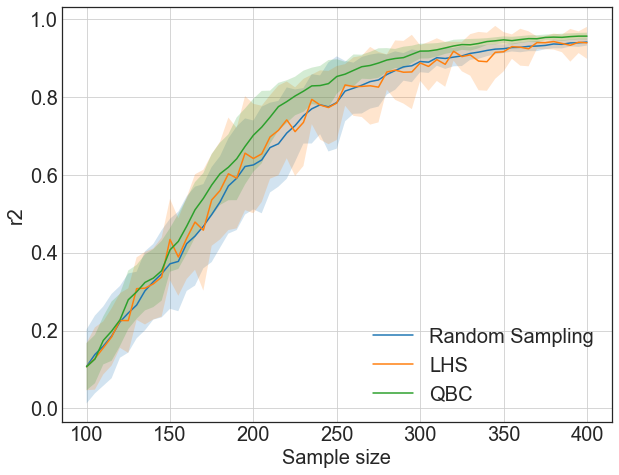

In [28]:
font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 20}

plt.rc('font', **font)


def plot_learning_curve_r2(df_target, label, title=''):
    df_target_filt = df_target[df_target.Model == mdl]
    df_target_mean = df_target_filt.groupby(['Model', 'Training_Size']).r2_val.mean().reset_index()
    df_target_std = df_target_filt.groupby(['Model', 'Training_Size']).r2_val.std().reset_index()
    plt.plot(df_target_mean.Training_Size, df_target_mean.r2_val, label=label, linestyle='-')
    plt.fill_between(df_target_mean.Training_Size, df_target_mean.r2_val - df_target_std.r2_val,
                     df_target_mean.r2_val + df_target_std.r2_val, alpha=0.2)
    ax.set_xlabel('Sample size')
    ax.set_ylabel('r2')
    ax.legend(loc='best')
    #plt.title(title)
    plt.grid()
    #plt.figure(figsize=(6,6))
    return plt

metadata = pred_key + '_SzTr_' + str(seedSize) + '+' + str(size_train_set) + '_SzTest_' + str(
    size_test_set) + '_CV_' + str(cv_folds) + '_BatchSz_' + str(batchSize) + '_CommitteePred_' + str(
    committee_predictor) + '_CommitteeSize_' + str(numCommitteeMembers) + '_PoolSetSize_' + str(PoolSetSize)

# res_df_qbc_filt = res_df_qbc[res_df_qbc['Training_Size'].isin(res_df_lhc.Training_Size.unique())]
# res_df_al_gpr_filt = res_df_al_gpr[res_df_al_gpr['Training_Size'].isin(res_df_lhc.Training_Size.unique())]

for mdl in res_df_random.Model.unique():
    with plt.style.context('seaborn-white'):
        fig = plt.figure(figsize=(9, 7))
        ax = fig.add_subplot(111)
        plot_learning_curve_r2(res_df_random, 'Random Sampling', metadata)
        plot_learning_curve_r2(res_df_lhc, 'LHS', metadata)
        plot_learning_curve_r2(res_df_qbc, 'QBC', metadata)
        #plot_learning_curve_r2(res_df_al_gpr, 'al_gpr', metadata)
        plt.legend(loc='lower right')
        plt.tight_layout()
        fig.savefig('puma_32_nm_al_lhc_mcs_results_' + mdl + '.png', dpi=300)
        plt.show()

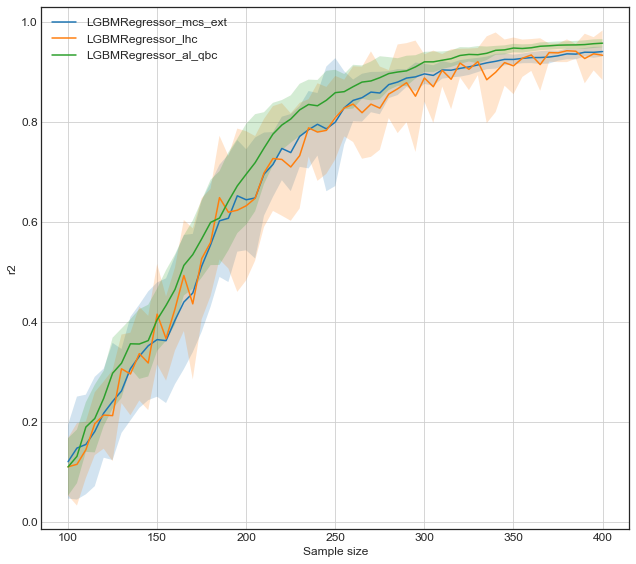

In [82]:
font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)


def plot_learning_curve_r2(df_target, label, title=''):
    df_target_filt = df_target[df_target.Model == mdl]
    df_target_mean = df_target_filt.groupby(['Model', 'Training_Size']).r2_val.mean().reset_index()
    df_target_std = df_target_filt.groupby(['Model', 'Training_Size']).r2_val.std().reset_index()
    plt.plot(df_target_mean.Training_Size, df_target_mean.r2_val, label=mdl + '_' + label, linestyle='-')
    plt.fill_between(df_target_mean.Training_Size, df_target_mean.r2_val - df_target_std.r2_val,
                     df_target_mean.r2_val + df_target_std.r2_val, alpha=0.2)
    ax.set_xlabel('Sample size')
    ax.set_ylabel('r2')
    ax.legend(loc='best')
    #plt.title(title)
    plt.grid()
    #plt.figure(figsize=(6,6))
    return plt

metadata = pred_key + '_SzTr_' + str(seedSize) + '+' + str(size_train_set) + '_SzTest_' + str(
    size_test_set) + '_CV_' + str(cv_folds) + '_BatchSz_' + str(batchSize) + '_CommitteePred_' + str(
    committee_predictor) + '_CommitteeSize_' + str(numCommitteeMembers) + '_PoolSetSize_' + str(PoolSetSize)

# res_df_qbc_filt = res_df_qbc[res_df_qbc['Training_Size'].isin(res_df_lhc.Training_Size.unique())]
# res_df_al_gpr_filt = res_df_al_gpr[res_df_al_gpr['Training_Size'].isin(res_df_lhc.Training_Size.unique())]

for mdl in res_df_random.Model.unique():
    with plt.style.context('seaborn-white'):
        fig = plt.figure(figsize=(9, 8))
        ax = fig.add_subplot(111)
        plot_learning_curve_r2(res_df_random, 'mcs_ext', metadata)
        plot_learning_curve_r2(res_df_lhc, 'lhc', metadata)
        plot_learning_curve_r2(res_df_qbc, 'al_qbc', metadata)
        #plot_learning_curve_r2(res_df_al_gpr, 'al_gpr', metadata)
        plt.tight_layout()
        fig.savefig('puma_32_nm_al_lhc_mcs_results_' + mdl + '.png', dpi=300)
        plt.show()

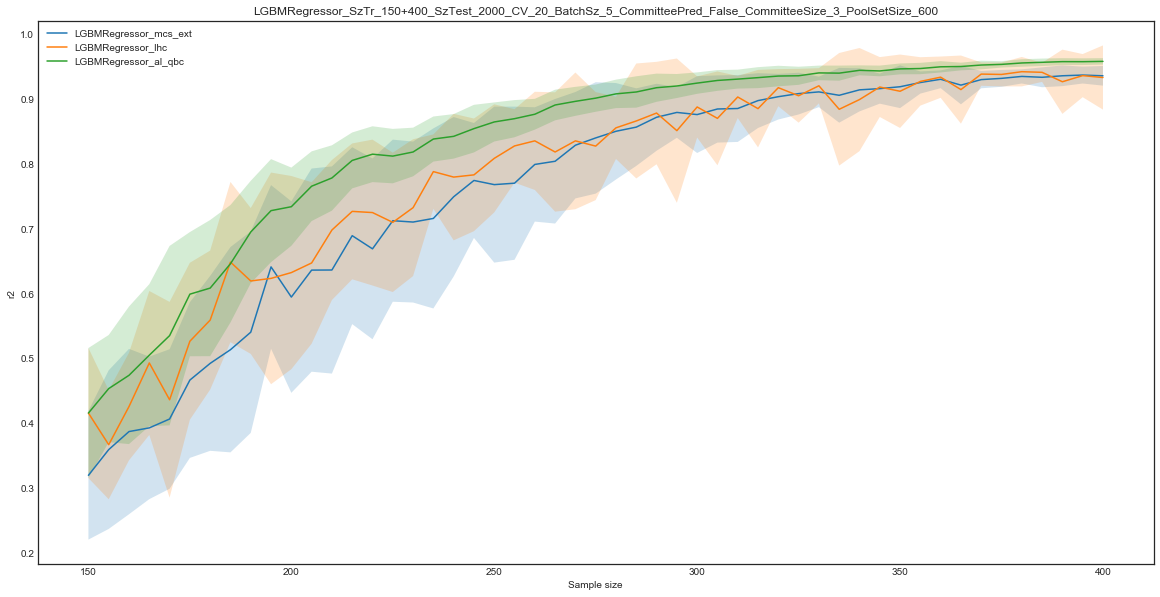

In [110]:
def plot_learning_curve_r2(df_target, label, title=''):
    df_target_filt = df_target[df_target.Model == mdl]
    df_target_mean = df_target_filt.groupby(['Model', 'Training_Size']).r2_val.mean().reset_index()
    df_target_std = df_target_filt.groupby(['Model', 'Training_Size']).r2_val.std().reset_index()
    plt.plot(df_target_mean.Training_Size, df_target_mean.r2_val, label=mdl + '_' + label, linestyle='-')
    plt.fill_between(df_target_mean.Training_Size, df_target_mean.r2_val - df_target_std.r2_val,
                     df_target_mean.r2_val + df_target_std.r2_val, alpha=0.2)
    ax.set_xlabel('Sample size')
    ax.set_ylabel('r2')
    ax.legend(loc='best')
    plt.title(title)
    return plt

metadata = pred_key + '_SzTr_' + str(seedSize) + '+' + str(size_train_set) + '_SzTest_' + str(
    size_test_set) + '_CV_' + str(cv_folds) + '_BatchSz_' + str(batchSize) + '_CommitteePred_' + str(
    committee_predictor) + '_CommitteeSize_' + str(numCommitteeMembers) + '_PoolSetSize_' + str(PoolSetSize)

# res_df_qbc_filt = res_df_qbc[res_df_qbc['Training_Size'].isin(res_df_lhc.Training_Size.unique())]
# res_df_al_gpr_filt = res_df_al_gpr[res_df_al_gpr['Training_Size'].isin(res_df_lhc.Training_Size.unique())]

for mdl in res_df_random.Model.unique():
    with plt.style.context('seaborn-white'):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111)
        plot_learning_curve_r2(res_df_random, 'mcs_ext', metadata)
        plot_learning_curve_r2(res_df_lhc, 'lhc', metadata)
        plot_learning_curve_r2(res_df_qbc, 'al_qbc', metadata)
        #plot_learning_curve_r2(res_df_al_gpr, 'al_gpr', metadata)
        # fig.savefig('al_lhc_mcs_results' + mdl + '.png', dpi=300)
        plt.show()

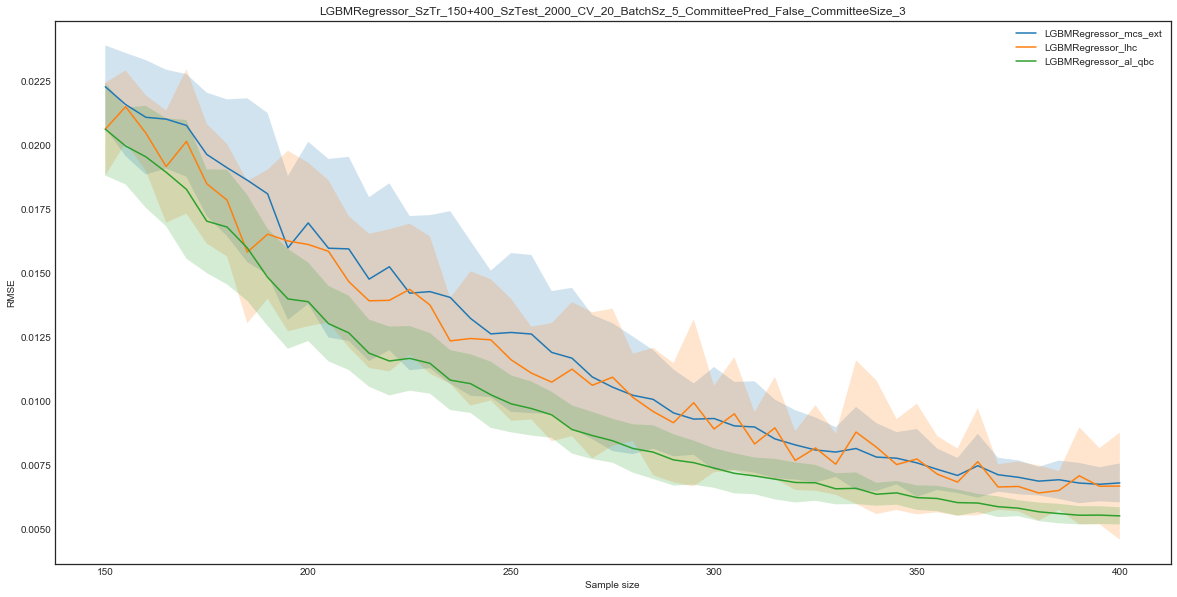

In [26]:
def plot_learning_curve_rmse(df_target, label, title=''):
    df_target_filt = df_target[df_target.Model == mdl]
    df_target_mean = df_target_filt.groupby(['Model', 'Training_Size']).RMSE.mean().reset_index()
    df_target_std = df_target_filt.groupby(['Model', 'Training_Size']).RMSE.std().reset_index()
    plt.plot(df_target_mean.Training_Size, df_target_mean.RMSE, label=mdl + '_' + label, linestyle='-')
    plt.fill_between(df_target_mean.Training_Size, df_target_mean.RMSE - df_target_std.RMSE,
                     df_target_mean.RMSE + df_target_std.RMSE, alpha=0.2)
    ax.set_xlabel('Sample size')
    ax.set_ylabel('RMSE')
    ax.legend(loc='best')
    plt.title(title)
    return plt

metadata = pred_key + '_SzTr_' + str(seedSize) + '+' + str(size_train_set) + '_SzTest_' + str(
    size_test_set) + '_CV_' + str(cv_folds) + '_BatchSz_' + str(batchSize) + '_CommitteePred_' + str(
    committee_predictor) + '_CommitteeSize_' + str(numCommitteeMembers)

for mdl in res_df_random.Model.unique():
    with plt.style.context('seaborn-white'):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111)
        plot_learning_curve_rmse(res_df_random, 'mcs_ext', metadata)
        plot_learning_curve_rmse(res_df_lhc, 'lhc', metadata)
        plot_learning_curve_rmse(res_df_qbc, 'al_qbc', metadata)
        #plot_learning_curve_rmse(res_df_al_gpr, 'al_gpr', metadata)
        # fig.savefig('al_lhc_mcs_results' + mdl + '.png', dpi=300)
        plt.show()

# Old GPR

In [69]:
count_gpr = 0

In [70]:
PoolSetSize = 251
seedSize = 150
n_queries = 250

lgbmParams = {  # 'learning_rate': 0.1,
    'n_estimators': 100,
    'objective': 'regression',
    'n_jobs': 1,
    'random_state': seed_list[count_gpr]
    }

predictor = lightgbm.LGBMRegressor(**lgbmParams)
print('seed {}'.format(count_gpr))
#print('seed {}'.format(count_gpr))
np.random.seed(seed_list[count_gpr])
train_data = np.array(latin_hypercube_generator(seedSize, actual_lows, actual_highs, variables_, reference_regr))
pool_data = np.array(latin_hypercube_generator(PoolSetSize, actual_lows, actual_highs, variables_, reference_regr))
# --------> STANDARDIZATION OF DATA SETS (subtraction of the mean, division by standard deviation) <------------------
min_data, max_data, data_all_norm = normalize(np.concatenate((train_data, pool_data, test_data), axis=0))
X_train = train_data[:, :-1]
X_pool = pool_data[:, :-1]
y_train = train_data[:, -1].reshape((-1, 1))
y_pool = pool_data[:, -1].reshape((-1, 1))
X_test = test_data[:, :-1]
y_test = test_data[:, -1]

# NORMALIZED DATA
X_train_norm = data_all_norm[:train_data.shape[0], :-1]
y_train_norm = data_all_norm[:train_data.shape[0], -1].reshape((-1, 1))
X_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], :-1]
y_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], -1].reshape((-1, 1))
X_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, :-1]
y_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, -1].reshape((-1, 1))

def GP_regression_std(regressor, X):
    _, std = regressor.predict(X, return_std=True)
    query_idx = np.argmax(std)
    return query_idx, X[query_idx]

from modAL.models import ActiveLearner
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF

#n_initial = 50
kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
         + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

committee = ActiveLearner(
    estimator=GaussianProcessRegressor(kernel=kernel),
    query_strategy=GP_regression_std,
    X_training=X_train_norm, y_training=y_train_norm.ravel()
)
#committee.fit(X_train_norm, y_train_norm.ravel())
qbc_y_norm = committee.predict(X_test_norm)
qbc_y = max_data[-1].reshape((-1, 1)) - qbc_y_norm * (
            max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))

preds_qbc = np.ravel(qbc_y)
targets_qbc = np.ravel(y_test)
r2_score(targets_qbc, preds_qbc)



import warnings
warnings.filterwarnings("ignore")

#  -------->  MODEL FITTING  <------------------
predictor.fit(X_train_norm, y_train_norm.ravel())
#  -------->  PREDICTION  <------------------
qbc_y_norm = predictor.predict(X_test_norm)
# -------->  DENORMALIZATION OF PREDICTED VALUES  <------------------
qbc_y = max_data[-1].reshape((-1, 1)) - qbc_y_norm * (
            max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))
# -------->  Evaluation  <------------------
preds_qbc = np.ravel(qbc_y)
targets_qbc = np.ravel(y_test)
print('AL GPR before, train size {}'.format(X_train_norm.shape[0]))
#print(X_train_norm[0])
print(r2_score(targets_qbc, preds_qbc))
      
#np.random.seed(12345)
for idx in range(n_queries):
    query_idx, query_instance = committee.query(X_pool_norm)
    #print(X_pool_norm[0])
#     print(query_idx)
#     print(query_instance)
    
    #X_train = np.append(X_train, X_pool[query_idx].reshape(1,-1), axis=0)
    #y_train = np.append(y_train, y_pool[query_idx].reshape(1,-1), axis=0)
    X_train_norm = np.append(X_train_norm, X_pool_norm[query_idx].reshape(1,-1), axis=0)
    y_train_norm = np.append(y_train_norm, y_pool_norm[query_idx].reshape(1,-1), axis=0)
    
    committee.teach(X_pool_norm[[query_idx]], y_pool_norm[[query_idx]].ravel())
    
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx, axis=0)
    X_pool_norm = np.delete(X_pool_norm, query_idx, axis=0)
    y_pool_norm = np.delete(y_pool_norm, query_idx, axis=0)
    
#  -------->  MODEL FITTING  <------------------
predictor.fit(X_train_norm, y_train_norm.ravel())
#  -------->  PREDICTION  <------------------
qbc_y_norm = predictor.predict(X_test_norm)
# -------->  DENORMALIZATION OF PREDICTED VALUES  <------------------
qbc_y = max_data[-1].reshape((-1, 1)) - qbc_y_norm * (
            max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))
# -------->  Evaluation  <------------------
preds_qbc = np.ravel(qbc_y)
targets_qbc = np.ravel(y_test)
print('AL GPR after, train size {}'.format(X_train_norm.shape[0]))
print(r2_score(targets_qbc, preds_qbc))
count_gpr += 1

seed 1
AL GPR before, train size 150
0.2847234742263258
AL GPR after, train size 400
0.9459554964591618


# Tune QBC

In [32]:
count_qbc= 0

In [23]:
count_qbc= 2
PoolSetSize = 260 #400
batchSize = 5
seedSize = 150
n_queries = 50

numCommitteeMembers = 3

results_qbc_t = []
learner_list = []
results_qbc_t = []

startTime = datetime.now()
for i in range(numCommitteeMembers):
    lgbmParams = {  # 'learning_rate': 0.1,
        'n_estimators': 100,
        'objective': 'regression',
        'n_jobs': 7,
        'random_state': i*100
        }
    predictor = lightgbm.LGBMRegressor(**lgbmParams)
    learner_list.append(ActiveLearner(estimator=predictor,
                                      # estimator=sklearn.base.clone(predictor),
                                      X_training=X_train_norm,
                                      y_training=y_train_norm.ravel(),
                                      bootstrap_init=True))
committee = CommitteeRegressor(learner_list=learner_list, query_strategy=max_std_sampling)
np.random.seed(seed_list[count_qbc])
print('seed {}'.format(count_qbc))
train_data = np.array(latin_hypercube_generator(seedSize, actual_lows, actual_highs, variables_, reference_regr))
#print(train_data[0])
#np.random.seed(seed_list[cv])
pool_data = np.array(latin_hypercube_generator(PoolSetSize, actual_lows, actual_highs, variables_, reference_regr))
#print(pool_data[0])
print('1')
# --------> STANDARDIZATION OF DATA SETS (subtraction of the mean, division by standard deviation) <------------------
min_data, max_data, data_all_norm = normalize(np.concatenate((train_data, pool_data, test_data), axis=0))
X_train = train_data[:, :-1]
X_pool = pool_data[:, :-1]
y_train = train_data[:, -1].reshape((-1, 1))
y_pool = pool_data[:, -1].reshape((-1, 1))
X_test = test_data[:, :-1]
y_test = test_data[:, -1]

# NORMALIZED DATA
X_train_norm = data_all_norm[:train_data.shape[0], :-1]
y_train_norm = data_all_norm[:train_data.shape[0], -1].reshape((-1, 1))
X_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], :-1]
y_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], -1].reshape((-1, 1))
X_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, :-1]
y_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, -1].reshape((-1, 1))
print('1')


committee.fit(X_train_norm, y_train_norm.ravel())
 #  -------->  Initial Evaluation  <------------------
if committee_predictor:
    #  -------->  PREDICTION  <------------------
    qbc_y_norm = committee.predict(X_test_norm)
else:
    #  -------->  MODEL FITTING  <------------------
    predictor.fit(X_train_norm, y_train_norm.ravel())
    #  -------->  PREDICTION  <------------------
    qbc_y_norm = predictor.predict(X_test_norm)
print('1')
qbc_y = max_data[-1].reshape((-1, 1)) - qbc_y_norm * (max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))
preds_qbc = np.ravel(qbc_y)
targets_qbc = np.ravel(y_test)

#print('QBC before, train size {}'.format(X_train_norm.shape[0]))
#print(r2_score(targets_qbc, preds_qbc))



for itter in range(n_queries+1):
    #print(itter)
    if committee_predictor:
        #  -------->  MODEL FITTING  <------------------
        committee.teach(X_train_norm, y_train_norm.ravel())
        #  -------->  PREDICTION  <------------------
        qbc_y_norm = committee.predict(X_test_norm)
    else:
        #committee.teach(X_train_norm, y_train_norm.ravel())
        #  -------->  MODEL FITTING  <------------------
        predictor.fit(X_train_norm, y_train_norm.ravel())
        #  -------->  PREDICTION  <------------------
        qbc_y_norm = predictor.predict(X_test_norm)

    # -------->  DENORMALIZATION OF PREDICTED VALUES  <------------------
    qbc_y = max_data[-1].reshape((-1, 1)) - qbc_y_norm * (max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))
    preds_qbc = np.ravel(qbc_y)
    targets_qbc = np.ravel(y_test)
    #print('qbc after, train size {}'.format(seedSize + num_itter*batchSize))

    r2_val = r2_score(targets_qbc, preds_qbc)
    print('size {}, r2 {}'.format(X_train_norm.shape[0], r2_val))
    rmse_val = rmse(targets_qbc, preds_qbc)

    results_qbc_t.append({'Model': pred_key, 'CV': cv, 'Training_Size': X_train_norm.shape[0],
                   'RMSE': rmse_val, 'r2_val': r2_val})

    # -------->  Pick new point  <------------------
    query_idx, query_instance = committee.query(X=X_pool_norm, n_instances=batchSize)
    X_train = np.append(X_train, X_pool[query_idx], axis=0)
    y_train = np.append(y_train, y_pool[query_idx], axis=0)
    X_train_norm = np.append(X_train_norm, X_pool_norm[query_idx], axis=0)
    y_train_norm = np.append(y_train_norm, y_pool_norm[query_idx], axis=0)
    committee.teach(X_pool_norm[query_idx],
                    y_pool_norm.ravel()[query_idx])  # train committee on newly added data
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx, axis=0)
    X_pool_norm = np.delete(X_pool_norm, query_idx, axis=0)
    y_pool_norm = np.delete(y_pool_norm, query_idx, axis=0)
    # print(X_pool_norm.shape)

endTime = datetime.now()
print('Total time fold {} trainSize {}: {} '.format(cv, X_train_norm.shape[0], (endTime - startTime) / 60))
res_df_qbc = pd.DataFrame(results_qbc_t)
count_qbc+=1

seed 2
1
1
1
size 150, r2 0.35445386655170497
size 155, r2 0.340873770610048
size 160, r2 0.38841403268328645
size 165, r2 0.3864077306869165
size 170, r2 0.4390538958775101
size 175, r2 0.5588433343854644
size 180, r2 0.5095936092298412
size 185, r2 0.6942965612891441
size 190, r2 0.7167600911786798
size 195, r2 0.7644677264409534
size 200, r2 0.6572942766775371
size 205, r2 0.7828379240048782
size 210, r2 0.7918665687182542
size 215, r2 0.7886589649560223
size 220, r2 0.8171275667250548
size 225, r2 0.8138557154221708
size 230, r2 0.8127679410582134
size 235, r2 0.8338991422011794
size 240, r2 0.8369270601832728
size 245, r2 0.8487277747863331
size 250, r2 0.8823386245033785
size 255, r2 0.8837254795285228
size 260, r2 0.9076315463111355
size 265, r2 0.8849960580669709
size 270, r2 0.9055399258336457
size 275, r2 0.8920317275598293
size 280, r2 0.8733776113192481
size 285, r2 0.911010074672587
size 290, r2 0.8983539639679428
size 295, r2 0.8971737226492815
size 300, r2 0.905383316304

In [111]:
np.random.seed(seed_list[4])
train_data = np.array(latin_hypercube_generator(150, actual_lows, actual_highs, variables_, reference_regr))
pool_data = np.array(latin_hypercube_generator(250, actual_lows, actual_highs, variables_, reference_regr))
min_data, max_data, data_all_norm = normalize(np.concatenate((train_data, pool_data, test_data), axis=0))
X_train = train_data[:, :-1]
X_pool = pool_data[:, :-1]
y_train = train_data[:, -1].reshape((-1, 1))
y_pool = pool_data[:, -1].reshape((-1, 1))
X_test = test_data[:, :-1]
y_test = test_data[:, -1]

# NORMALIZED DATA
X_train_norm = data_all_norm[:train_data.shape[0], :-1]
y_train_norm = data_all_norm[:train_data.shape[0], -1].reshape((-1, 1))
X_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], :-1]
y_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], -1].reshape((-1, 1))
X_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, :-1]
y_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, -1].reshape((-1, 1))

X_t = np.concatenate((X_train_norm, X_pool_norm), axis=0)
y_t = np.concatenate((y_train_norm, y_pool_norm), axis=0)
predictor.fit(X_t, y_t.ravel())

bc_y_norm = predictor.predict(X_test_norm)

# -------->  DENORMALIZATION OF PREDICTED VALUES  <------------------
qbc_y = max_data[-1].reshape((-1, 1)) - qbc_y_norm * (max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))
preds_qbc = np.ravel(qbc_y)
targets_qbc = np.ravel(y_test)
#print('qbc after, train size {}'.format(seedSize + num_itter*batchSize))
#print(r2_score(targets_qbc, preds_qbc))

r2_val = r2_score(targets_qbc, preds_qbc)
print('size {}, r2 {}'.format(X_t.shape[0], r2_val))

size 400, r2 0.9359631045189958


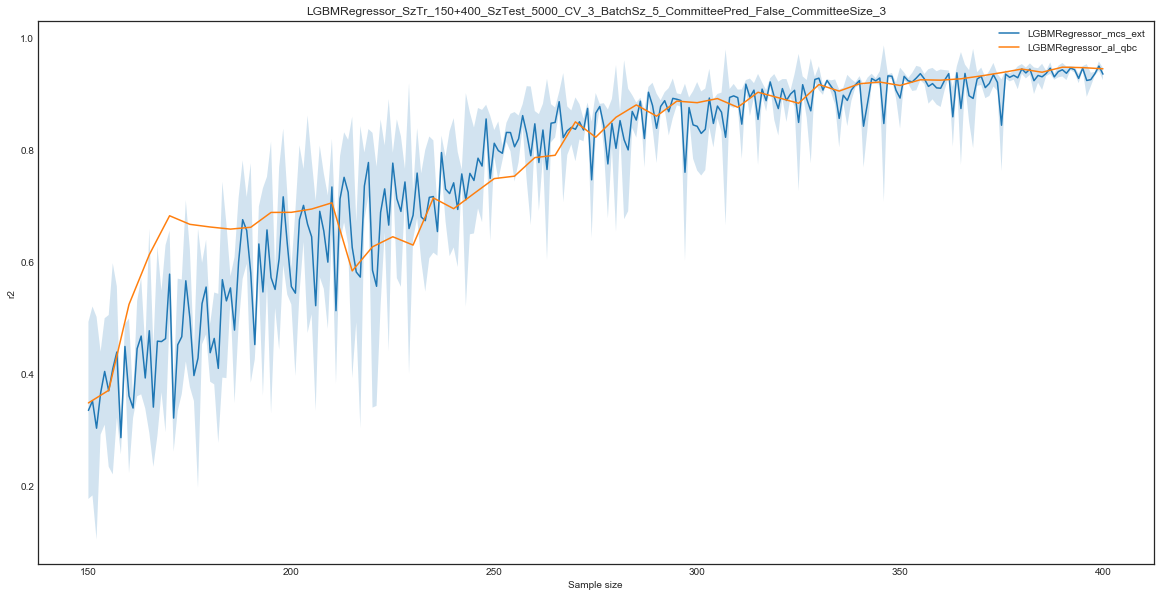

In [34]:
def plot_learning_curve_r2(df_target, label, title=''):
    df_target_filt = df_target[df_target.Model == mdl]
    df_target_mean = df_target_filt.groupby(['Model', 'Training_Size']).r2_val.mean().reset_index()
    df_target_std = df_target_filt.groupby(['Model', 'Training_Size']).r2_val.std().reset_index()
    plt.plot(df_target_mean.Training_Size, df_target_mean.r2_val, label=mdl + '_' + label, linestyle='-')
    plt.fill_between(df_target_mean.Training_Size, df_target_mean.r2_val - df_target_std.r2_val,
                     df_target_mean.r2_val + df_target_std.r2_val, alpha=0.2)
    ax.set_xlabel('Sample size')
    ax.set_ylabel('r2')
    ax.legend(loc='best')
    plt.title(title)
    return plt

metadata = pred_key + '_SzTr_' + str(seedSize) + '+' + str(size_train_set) + '_SzTest_' + str(
    size_test_set) + '_CV_' + str(cv_folds) + '_BatchSz_' + str(batchSize) + '_CommitteePred_' + str(
    committee_predictor) + '_CommitteeSize_' + str(numCommitteeMembers)

# res_df_qbc_filt = res_df_qbc[res_df_qbc['Training_Size'].isin(res_df_lhc.Training_Size.unique())]
# res_df_al_gpr_filt = res_df_al_gpr[res_df_al_gpr['Training_Size'].isin(res_df_lhc.Training_Size.unique())]

for mdl in res_df_random.Model.unique():
    with plt.style.context('seaborn-white'):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111)
        plot_learning_curve_r2(res_df_random, 'mcs_ext', metadata)
        #plot_learning_curve_r2(res_df_lhc, 'lhc', metadata)
        plot_learning_curve_r2(res_df_qbc, 'al_qbc', metadata)
        #plot_learning_curve_r2(res_df_al_gpr, 'al_gpr', metadata)
        # fig.savefig('al_lhc_mcs_results' + mdl + '.png', dpi=300)
        plt.show()

In [10]:
for mdl in res_df_random.Model.unique():
    with plt.style.context('seaborn-white'):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111)
        plot_learning_curve_r2(res_df_random, 'mcs_ext', metadata)
        #plot_learning_curve_r2(res_df_lhc, 'lhc', metadata)
        plot_learning_curve_r2(res_df_qbc, 'al_qbc', metadata)
        plot_learning_curve_r2(res_df_al_gpr, 'al_gpr', metadata)
        # fig.savefig('al_lhc_mcs_results' + mdl + '.png', dpi=300)
        plt.show()

NameError: name 'res_df_random' is not defined